# **News Recommendation System**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
# Below libraries are for text processing using NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Below libraries are for feature representation using sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Below libraries are for similarity matrices using sklearn
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
import warnings
warnings.filterwarnings('ignore')

## **2. Loading datasets**

In [ ]:
news_articles = pd.read_json("/content/drive/MyDrive/Project_team_6/News_Category_Dataset_v2.json", lines = True)

In [ ]:
news_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [ ]:
news_articles.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [ ]:
news_articles.shape

(200853, 6)

In [ ]:
print("Dataset has {} observations with {} features".format(news_articles.shape[0],news_articles.shape[1]))

Dataset has 200853 observations with 6 features


In [ ]:
news_articles['category'].unique()

array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'FIFTY', 'ARTS',
       'WELLNESS', 'PARENTING', 'HOME & LIVING', 'STYLE & BEAUTY',
       'DIVORCE', 'WEDDINGS', 'FOOD & DRINK', 'MONEY', 'ENVIRONMENT',
       'CULTURE & ARTS'], dtype=object)

In [ ]:
news_articles['category'].nunique()

41

## **3. Data Preprocessing**

### ***3.a) Fetching only the articles from 2018***

In [ ]:
import time


In [ ]:
news_articles = news_articles[news_articles['date'] >= pd.Timestamp(2018,1,1)]

In [ ]:
news_articles.shape

(8583, 6)

### **3.b) Removing all the short headline articles**

In [ ]:
news_articles[news_articles['headline'].apply(lambda x: len(x.split())<5)].head(5)

,category,headline,authors,link,short_description,date
1269,POLITICS,Corruption Is Bad,Zach Carter,https://www.huffingtonpost.com/entry/government-anti-corruption-oversight_us_5ae8e4ebe4b06748dc8d4b43,A new proposal would actually do something about it.,2018-05-02
1888,ENTERTAINMENT,Meeting Mr. Wright,Leigh Blickley,https://www.huffingtonpost.com/entry/jeffrey-wright-westworld-hbo_us_5ad7b9bae4b03c426daaf38d,"He’s “that guy” in every HBO series — and ""that android"" in “Westworld” — but chances are, you don't know anything about the real Jeffrey Wright.",2018-04-21
2868,BLACK VOICES,MLK's Funeral: Rare Photos,"FOTO, Editorial Partner",https://www.huffingtonpost.com/entry/mlks-funeral-rare-photos_us_5abe4882e4b0f8e848433755,Andrew Young was the executive director of the Southern Christian Leadership Conference (SCLC); marched in (and was arrested,2018-04-03
3061,WEIRD NEWS,'The Early Worm Dies',Lee Moran,https://www.huffingtonpost.com/entry/reddit-shower-thoughts-2018-march-final_us_5abe2292e4b0f112dc9b9170,The 25 most profound “Shower Thoughts” on Reddit from the last week.,2018-03-30
3438,POLITICS,John Bolton's Anti-Muslim Hate,Christopher Mathias,https://www.huffingtonpost.com/entry/john-bolton-anti-muslim-bigot-hate-groups_us_5ab52bf2e4b008c9e5f6f1f9,Trump's new pick for national security adviser is close with some of the most unhinged anti-Muslim groups in America.,2018-03-23


In [ ]:
news_articles = news_articles[news_articles['headline'].apply(lambda x: len(x.split())>5)]
print("Total number of articles after removal of headlines with short title:", news_articles.shape[0])

Total number of articles after removal of headlines with short title: 8530


### **3.c) Checking and removing all the duplicates**

In [ ]:
news_articles.sort_values('headline',inplace=True, ascending=False)
duplicated_articles_series = news_articles.duplicated('headline', keep = False)
news_articles = news_articles[~duplicated_articles_series]
print("Total number of articles after removing duplicates:", news_articles.shape[0])

Total number of articles after removing duplicates: 8485


### **3.d) Checking for missing values**

In [ ]:
news_articles.isna().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

No missing values are present

## **4. Basic Data Exploration**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

### **4.a) Basic statistics - Number of articles,authors,categories**

In [ ]:
print("Total number of articles : ", news_articles.shape[0])
print("Total number of authors : ", news_articles["authors"].nunique())
print("Total number of unqiue categories : ", news_articles["category"].nunique())

Total number of articles :  8485
Total number of authors :  892
Total number of unqiue categories :  26


### **4.b) Distribution of articles category-wise**

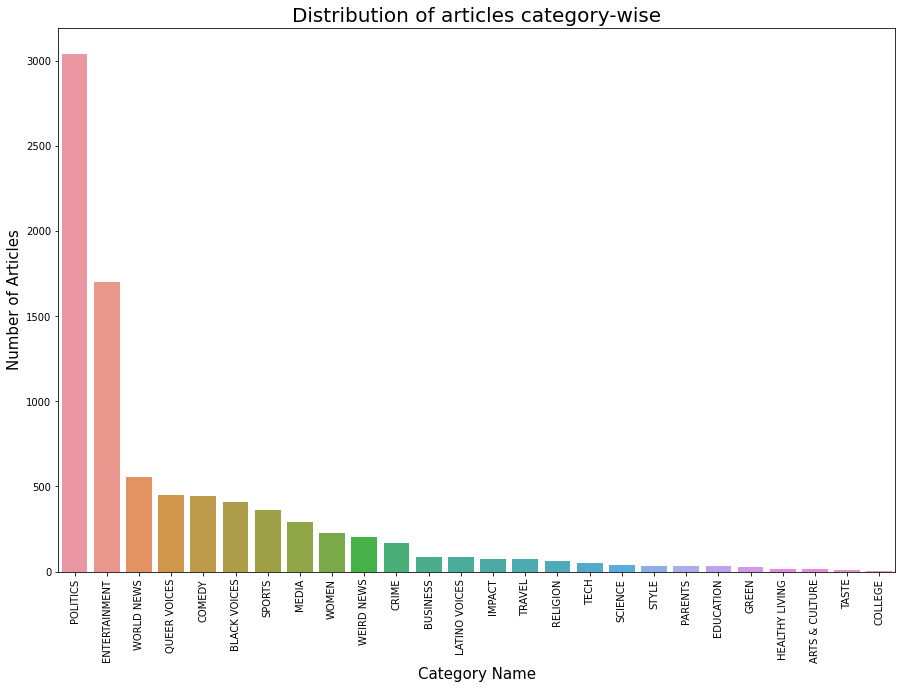

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(data=news_articles,x=news_articles["category"].value_counts().index, y=news_articles["category"].value_counts().values)
plt.xticks(rotation=90)
plt.xlabel('Category Name',fontsize = 15)
plt.ylabel('Number of Articles',fontsize = 15)
plt.title('Distribution of articles category-wise',fontsize = 20)
plt.show()

From the bar chart, we can observe that politics category has highest number of articles then entertainment and so on.

### **4.c) Number of articles per month**

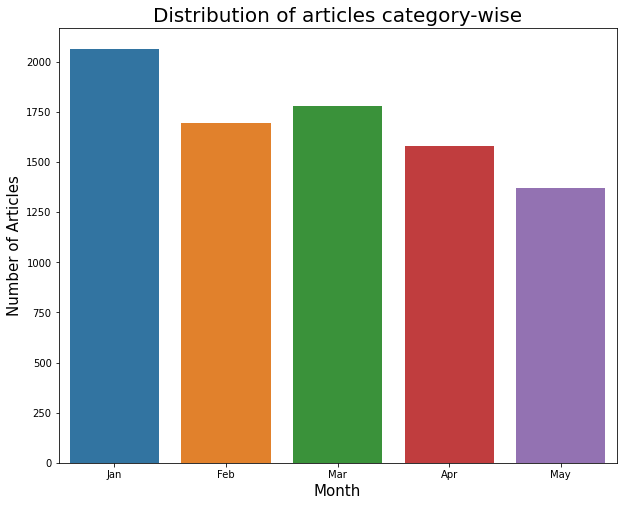

In [ ]:
news_articles_per_month = news_articles.resample('m',on = 'date')['headline'].count()
plt.figure(figsize=(10,8))
sns.barplot(data=news_articles,x=news_articles_per_month.index.strftime("%b"), y=news_articles_per_month)
plt.xticks
plt.xlabel('Month',fontsize = 15)
plt.ylabel('Number of Articles',fontsize = 15)
plt.title('Distribution of articles category-wise',fontsize = 20)
plt.show()

From the bar chart, we can observe that January month has highest number of articles then March and so on.

### **4.d) PDF for the length of headlines**

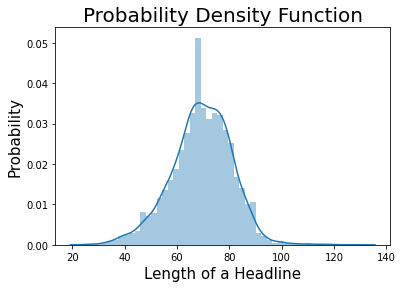

In [ ]:
data = pd.DataFrame(news_articles['headline'].str.len())
res = sns.distplot(data)
plt.xlabel('Length of a Headline',fontsize = 15)
plt.ylabel('Probability',fontsize = 15)
plt.title('Probability Density Function',fontsize = 20)
plt.show()


The probability distribution function of headline length is almost similar to a Guassian distribution, where most of the headlines are 58 to 80 words long in length

**INFERENCES:** 


*   Major part of the news articles comes under Politics and Entertainment category.
*   Most of the headlines have words between 58 to 80.



In [ ]:
news_articles_temp = news_articles.copy()
na=news_articles.copy()

# **5. Text Preprocessing**

### **5.a) Removing Punctuation**

In [ ]:
import string
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
na['headline'] = na['headline'].apply(lambda x:remove_punctuation(x))


### **5.b) Lowering**

In [ ]:
na['headline'] = na['headline'].apply(lambda x:x.lower())

### **5.c) Tokenization**

In [ ]:
import nltk
nltk.download('punkt')

def tokenization(text):
    words = nltk.word_tokenize(text)
    return words
na['headline'] = na['headline'].apply(lambda x:tokenization(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### **5.d) Stopwords Removal**

In [ ]:
import nltk

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output
na['headline'] = na['headline'].apply(lambda x:remove_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **5.e) Lemmatization**

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
lemm=WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
  lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
  return lemm_text
na['headline'] = na['headline'].apply(lambda x:lemmatizer(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
na.head()

,category,headline,authors,link,short_description,date
2932,QUEER VOICES,"[‘, grace, ’, creator, donate, gay, bunny, boo...",Elyse Wanshel,https://www.huffingtonpost.com/entry/will-grac...,It's about to be a lot easier for kids in Mike...,2018-04-02
4487,QUEER VOICES,"[‘, voice, ’, blind, audition, make, history, ...","Lyndsey Parker, Yahoo Entertainment",https://www.huffingtonpost.com/entry/the-voice...,"Austin Giorgio, 21: “How Sweet It Is (To Be Lo...",2018-03-06
8255,QUEER VOICES,"[‘, penumbra, ’, queer, audio, drama, ’, know,...","Sarah Emily Baum, ContributorFreelance Writer",https://www.huffingtonpost.com/entry/the-penum...,"Young, fun, fantastical and, most notably, inc...",2018-01-05
744,COMEDY,"[‘, opposition, ’, give, trump, hot, lawyer]",Ed Mazza,https://www.huffingtonpost.com/entry/trump-hot...,"He's here to make a ""strong case"" for the pres...",2018-05-11
2893,ENTERTAINMENT,"[‘, stranger, thing, ’, fan, able, visit, upsi...",Elyse Wanshel,https://www.huffingtonpost.com/entry/stranger-...,"Hawkins is headed to Hollywood, Orlando and Si...",2018-04-03


# **6.Modelling**

### **6.a) Bag-of-Words with headline and Eucleadian distance**

In [ ]:
pd.set_option('display.max_colwidth', -1)  # To display a very long headline completely

In [ ]:
headline_vectorizer = CountVectorizer()
headline_features   = headline_vectorizer.fit_transform(news_articles_temp['headline'])

In [ ]:
def bag_of_words(row_index, num_similar_items):
    couple_dist = pairwise_distances(headline_features,headline_features[row_index])
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]
    df = pd.DataFrame({'publish_date': na['date'][indices].values,
               'headline':na['headline'][indices].values,
                'Euclidean similarity with the queried article': couple_dist[indices].ravel()})
    print("="*30,"Queried article details","="*30)
    print('headline : ',na['headline'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    #return df.iloc[1:,1]
    return df.iloc[1:,]

bag_of_words(133, 11) # Change the row index for any other queried article

============================== Queried article details ==============================
headline :  Can You Believe? Queer Eye Season 2 Drops Next Month

 ========================= Recommended articles :  =======================


,publish_date,headline,Euclidean similarity with the queried article
1,2018-04-23,"For The First Time, Here Are Jerry Garcia's Earliest Known Recorded Performances",3.605551
2,2018-01-30,GOP Congressman Calls For Undocumented SOTU Guests To Be Arrested On The Spot,3.605551
3,2018-01-12,"Alton Sterling's Family Seeks Release Of Controversial Video, Evidence",3.605551
4,2018-05-09,NY Legislature Has Plan In Place To Consider Replacements For Eric Schneiderman,3.741657
5,2018-05-08,Eric Schneiderman Has Always Been A Con Man,3.741657
6,2018-05-09,"Seth Meyers Decodes Teen Slang, Reveals What ‘Giuliani’ Really Means",3.741657
7,2018-01-22,"Lindsey Graham Slams Trump Aide, Says White House Staff Making Negotiations ‘Difficult’",3.741657
8,2018-05-17,"Boulder City Council Unanimously Votes To Ban Assault Weapons, High-Capacity Magazines",3.741657
9,2018-01-31,Trump Executive Order Helps Cement Guantanamo's Status As A Forever Prison,3.741657
10,2018-05-04,Alexa Can Remember Birthdays And Other Things For You Now,3.741657


### **6.b) TF-IDF**

In [ ]:
tfidf_headline_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_headline_features = tfidf_headline_vectorizer.fit_transform(news_articles_temp['headline'])

In [ ]:
def tfidf_based_model(row_index, num_similar_items):
    couple_dist = pairwise_distances(tfidf_headline_features,tfidf_headline_features[row_index])
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]
    df = pd.DataFrame({'publish_date': na['date'][indices].values,
               'headline':na['headline'][indices].values,
                'Euclidean similarity with the queried article': couple_dist[indices].ravel()})
    print("="*30,"Queried article details","="*30)
    print('headline : ',na['headline'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    
    #return df.iloc[1:,1]
    return df.iloc[1:,]
tfidf_based_model(133, 11)

============================== Queried article details ==============================
headline :  Can You Believe? Queer Eye Season 2 Drops Next Month

 ========================= Recommended articles :  =======================


,publish_date,headline,Euclidean similarity with the queried article
1,2018-01-31,Trump Executive Order Helps Cement Guantanamo's Status As A Forever Prison,1.242174
2,2018-01-23,"Matt Bomer, Zachary Quinto And More Prep 'Boys In The Band' For Broadway",1.256595
3,2018-02-13,New Jersey Deputy Mayor Compares Undocumented Immigrants To 'Rabid Raccoons',1.257048
4,2018-04-23,"For The First Time, Here Are Jerry Garcia's Earliest Known Recorded Performances",1.288824
5,2018-02-09,Government Runs Out Of Money Again As Congress Fails To Reach A Deal,1.292443
6,2018-02-09,2 Koreas Make History Marching Under Unified Flag In Olympics Opener,1.293377
7,2018-02-09,Team USA's Openly Gay Athletes Aren't Backing Down From Feud With Vice President,1.295394
8,2018-01-19,Chelsea Manning Officially On The Ballot For U.S. Senate Race In Maryland,1.296011
9,2018-04-26,James Comey Is 'Embarrassed And Ashamed' Of The Republican Party,1.299462
10,2018-04-16,"EPA Spending On Scott Pruitt's Soundproof Phone Booth Broke Federal Law, Government Watchdog Finds",1.299698


### **6.c) Bag-of-Words**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=5000,stop_words='english')
vectors=cv.fit_transform(na['short_description']).toarray()
from sklearn.metrics.pairwise import cosine_similarity
similarity=cosine_similarity(vectors)

In [ ]:
def recommendations(news):
    news_index=na[na['headline']==news].index[0]
    dist_per_news=similarity[4]
    news_list=sorted(list(enumerate(dist_per_news)),reverse=True,key=lambda x:x[1])[1:11]
    for i in news_list:
        print(na['headline'][i[0]])    
        print(dist_per_news)

In [ ]:
recommendations('Can You Believe? Queer Eye Season 2 Drops Next Month')

1 Person Dead After Shooting At Nashville, Tennessee, Mall
[0. 0. 0. ... 0. 0. 0.]
James Corden Reveals The Worst Part Of The Royal Wedding Ceremony
[0. 0. 0. ... 0. 0. 0.]
Shawn Mendes Says He Almost Starred In 'Love, Simon'
[0. 0. 0. ... 0. 0. 0.]
Israeli Troops Wound 13 On Gaza Border, Day After Deadly Protest
[0. 0. 0. ... 0. 0. 0.]
NHL Teams Honor Victims Of Canada's Junior Hockey Bus Crash
[0. 0. 0. ... 0. 0. 0.]
Drake Keeps Crushing Hard On ESPN Reporter Doris Burke
[0. 0. 0. ... 0. 0. 0.]
Report: Trump Scrapped South Korea Envoy Pick Over Split On Bombing North
[0. 0. 0. ... 0. 0. 0.]
Childish Gambino's 'This Is America' Hits No. 1 Spot In First Week
[0. 0. 0. ... 0. 0. 0.]
Twitter Bans GOP Candidate For Racist Meghan Markle Tweet
[0. 0. 0. ... 0. 0. 0.]
Kylie Jenner Announces The Name Of Her First Child
[0. 0. 0. ... 0. 0. 0.]


## Converting to pickle file for web hosting



In [ ]:
import pickle
pickle.dump(na,open('/content/drive/MyDrive/Project_team_6/news.pkl','wb'))
pickle.dump(similarity,open('/content/drive/MyDrive/Project_team_6/feature.pkl','wb'))

In [ ]:
!python3 "/content/drive/MyDrive/Project_team_6/App.ipynb"